<a href="https://colab.research.google.com/github/kaispace30098/amazon-order-invoice-checker/blob/main/Ming's_Mark_Inc_Amazon_uninvoiced_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

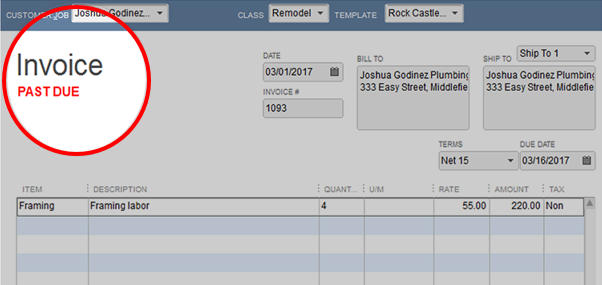

In [ ]:
#@title  1.Please Upload confirmed Purchase Orders from Vendor central
import pandas as pd
import io
from google.colab import files
import numpy as np


def read_dir_file(case_f):  # case_f = 0 for uploading one File and case_f = 1 for uploading one Zipped Directory
        #uploaded = files.upload()    # to upload a Full Directory, please Zip it first (use WinZip)
        for fn in uploaded.keys():
            name = fn  #.encode('utf-8')
            #print('\nfile after encode', name)
            #name = io.BytesIO(uploaded[name])
        if case_f == 0:    # case of uploading 'One File only'
            print('\n file name: ', name)
            return name
        else:   # case of uploading a directory and its subdirectories and files
            zfile = zipfile.ZipFile(name, 'r')   # unzip the directory 
            zfile.extractall()
            for d in zfile.namelist():   # d = directory
                print('\n main directory name: ', d)
                return d
 
#C3 UPLOAD PO sheet
uploaded = files.upload()
fileName = read_dir_file(0)
 
df_p=pd.read_excel(io.BytesIO(uploaded[fileName]), header=None,sheet_name='Line Items')[2:]
df_p.columns = df_p.iloc[0]# Dataset is now stored in a Pandas Dataframe
df_p=df_p.drop(df_p.index[[0]])
df_p['Hand Off End'] = pd.to_datetime(df_p['Hand Off End'], format='%d-%m-%Y')

In [ ]:
#@title  2.Please Upload Quickbooks Gowise invoices csv
uploaded = files.upload()
fileName = read_dir_file(0)
df_q1= pd.read_csv(io.BytesIO(uploaded[fileName]))


In [ ]:
#@title  3.Please Upload Quickbooks Camping invoices csv
uploaded = files.upload()
fileName = read_dir_file(0)
df_q2= pd.read_csv(io.BytesIO(uploaded[fileName]))

In [ ]:
#@title  4.Please Upload Vender Central invoiced list
uploaded = files.upload()
fileName = read_dir_file(0)
df_i= pd.read_csv(io.BytesIO(uploaded[fileName]))

In [ ]:
#@title ##☆☆Report1☆☆: Quickbooks: Check for bad-invoice
# concatinate two QB invoice sheets
frames = [df_q1, df_q2]
df_q=pd.concat(frames)
print(len(df_q1),len(df_q2),len(df_q))
df_q

# index and match function
def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
    match_value = return_array.loc[lookup_array == lookup_value]
    if match_value.empty:
        return f'"{lookup_value}" not found in QB!' if if_not_found == '' else if_not_found

    else:
        return match_value.tolist()[0]


df_i["PO"]=""
for i in range(0,len(df_i)):
  df_i['PO'].iloc[i]=xlookup(df_i['Invoice Number'].iloc[i], df_q['Num'],df_q['P.O. Number'])

df_i.to_csv('Correct POs from VC detail.csv',index=False) 
files.download('Correct POs from VC detail.csv')

In [ ]:
#@title ##★★Report2★★: Amazon: Uninvoiced confirmed POs (upload Report1) 

uploaded = files.upload()
fileName = read_dir_file(0)
df_i= pd.read_csv(io.BytesIO(uploaded[fileName]))

# index and match function
def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
    match_value = return_array.loc[lookup_array == lookup_value]
    if match_value.empty:
        return f'"{lookup_value}" not yet invoice!' if if_not_found == '' else if_not_found

    else:
        return match_value.tolist()[0]

df_p["Amazon invoice number"]=""
for i in range(0,len(df_p)):
  df_p['Amazon invoice number'].iloc[i]=xlookup(df_p['Order/PO Number'].iloc[i],df_i['PO'], df_i['Invoice Number'])

df_i['Invoice Date'] = pd.to_datetime(df_i['Invoice Date'], format='%m/%d/%Y')

polist=df_p[df_p['Hand Off End']>df_i['Invoice Date'].min()]['Order/PO Number'].unique()
dff=pd.DataFrame(polist, columns=['PO'] )
dff['shipdate']=""
dff['amazon invoice number']=""
dff['Vendor_code']=""
for i in range(0,len(dff)):
  dff['shipdate'].iloc[i]=xlookup(dff['PO'].iloc[i],df_p['Order/PO Number'],df_p['Hand Off End'])
  dff['amazon invoice number'].iloc[i]=xlookup(dff['PO'].iloc[i],df_p['Order/PO Number'],df_p['Amazon invoice number'])
  dff['Vendor_code'].iloc[i]=xlookup(dff['PO'].iloc[i],df_p['Order/PO Number'],df_p['Vendor Code'])
dff.to_csv('Amazon invoice.csv',index=False) 
files.download('Amazon invoice.csv')